In [3]:
import torch
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import warnings
import numpy as np
from transformers import  XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, DataCollatorForTokenClassification
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
from collections import Counter
import matplotlib.colors as mcolors




warnings.filterwarnings("ignore")

c:\coding\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up for labels and test data

In [4]:
def extract_refs(json_path):
    cultural_refs_tag = []
    cultural_refs_IDs = {}

    with open(json_path, "r") as f:
        cultural_data = json.load(f)
        cultural_refs_tag.extend([entry['tag'] for entry in cultural_data])
        cultural_refs_IDs.update({entry['tag']: entry['id'] for entry in cultural_data})

    return cultural_refs_tag, cultural_refs_IDs

ner_tags_path = "data/ner_tags.json"
cultural_ref_tags_path = "data/cultural_tags.json"

ner_tags, tag2id_ner = extract_refs(ner_tags_path)
cultural_tags, tag2id_cultural = extract_refs(cultural_ref_tags_path)

num_labels_culture = len(tag2id_cultural)
num_labels_ner = len(tag2id_ner)

id2tag_ner = {v: k for k, v in tag2id_ner.items()}
id2tag_cultural = {v: k for k, v in tag2id_cultural.items()}

In [5]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
test_data = "data/test_merged_output_cultural.conll"
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)

#### Tokenizing the test data

In [6]:
def parse_conllu(file_path):
    " This function create a usable dataset of the sparse .conllu file with the NER tags and cultural refferences"
    sentences = []
    tags = []
    cultural_references = []
    
    with open(file_path, "r",encoding="utf-8") as file:
        tokens = []
        ner_tags = []
        cultural_ref = []
        
        for line in file:
            line = line.strip()
                       
            if not line:
                if tokens:  
                    sentences.append(tokens)
                    tags.append(ner_tags)
                    cultural_references.append(cultural_ref)
              
                tokens = []
                ner_tags = []
                cultural_ref = []
                continue

            parts = line.split("\t")
            
            if len(parts) >= 3:
                token = parts[0]  
                ner_tag = parts[1] 
                cultural_ref_val = parts[2]
                
                tokens.append(token)
                ner_tags.append(ner_tag)
                cultural_ref.append(cultural_ref_val)
        
       
        if tokens:
            sentences.append(tokens)
            tags.append(ner_tags)
            cultural_references.append(cultural_ref)
    
    return sentences, tags, cultural_references

In [7]:
sentences_test, tags_test, cultural_refs_test = parse_conllu(test_data)
test_data = [{"tokens": s, "ner_tags": t, "cultural_ref": c} for s, t, c in zip(sentences_test, tags_test, cultural_refs_test)]
dataset_test = Dataset.from_list(test_data)

In [8]:
def tokenize_and_align_labels_with_cultural(example):
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    
    word_ids = tokenized.word_ids()
    ner_label_ids = []
    cultural_label_ids = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            ner_label_ids.append(-100)
            cultural_label_ids.append(-100)
        elif word_idx != previous_word_idx:
            ner_tag = example["ner_tags"][word_idx]
            cultural_tag = example["cultural_ref"][word_idx]

            ner_label_ids.append(tag2id_ner.get(ner_tag, -100))
            cultural_label_ids.append(tag2id_cultural.get(cultural_tag, -100))
        else:
            ner_label_ids.append(-100)
            cultural_label_ids.append(-100)

        previous_word_idx = word_idx

    tokenized["labels"] = ner_label_ids
    tokenized["cultural_ref"] = cultural_label_ids

    return tokenized


In [9]:
tokenized_test = dataset_test.map(tokenize_and_align_labels_with_cultural)

In [10]:
tokenized_test

Dataset({
    features: ['tokens', 'ner_tags', 'cultural_ref', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2952
})

In [11]:
# tokenized_test[7]

## 1. Inicialization of models

### 1.a. NER tagger 

In [12]:
ner_model = XLMRobertaForTokenClassification.from_pretrained("models/xlmr-ner-head/checkpoint-3018")
ner_model.eval()

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

### 1.a. Culture tagger 

In [13]:
cultural_model = XLMRobertaForTokenClassification.from_pretrained("models/xlmr-cultural-head/checkpoint-1200")
cultural_model.eval()

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

## 2. NER and Cultural prediction connection

### 2.a Getting the predictions from the NER model

In [17]:
dataloader = DataLoader(tokenized_test, batch_size=16, collate_fn=data_collator)

In [13]:
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [14]:
tokenized_test[7]

{'input_ids': tensor([     0,   1184,   1010,    206,   3448,     51, 128500,     41,    163,
         159910,  20244,  12759,  24585,    533,     51,  26249,      2,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1

In [15]:
all_predictions_ner = []
all_true_labels_ner = []
all_word_ids_ner = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        true_labels_ner = batch["labels"]
        outputs = ner_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        all_predictions_ner.extend(predictions.tolist())
        all_true_labels_ner.extend(true_labels_ner.tolist())
        all_word_ids_ner.extend(true_labels_ner.tolist())

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [16]:
preds_str = [[id2tag_ner[pred] for pred in seq] for seq in all_predictions_ner]
true_labels_str = [
    [id2tag_ner[label] if label != -100 else "O" for label in seq] 
    for seq in all_true_labels_ner]

In [17]:
## The missclassification of the NER model will  need a double check @Alex


# misclassified_ner = []

# for pred_seq, true_seq, word_id_seq in zip(all_predictions_ner, all_true_labels_ner, all_word_ids_ner):
#     for pred_id, true_id, word_id in zip(pred_seq, true_seq, word_id_seq):
#         if true_id == -100:
#             continue  # skip ignored tokens
        
#         if true_id != pred_id:  # misclassification
#             word = tokenizer.convert_ids_to_tokens(word_id)  # get token string
#             true_label = id2tag_ner[true_id]
#             pred_label = id2tag_ner[pred_id]
#             misclassified_ner.append((word_id, word, true_label, pred_label))

# df_misclassified_ner = pd.DataFrame(
#     misclassified_ner, columns=["Word ID", "Word", "True Label", "Predicted Label"]
# )

# df_misclassified_ner

In [18]:
preds_str[7]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-MISC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [19]:
true_labels_str[7]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-MISC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

##### Evalution of NER model

In [20]:
flat_true = []
flat_pred = []

for true_seq, pred_seq in zip(true_labels_str, preds_str):
    for t, p in zip(true_seq, pred_seq):
        if t != "O":
            flat_true.append(t)
            flat_pred.append(p)

print(classification_report(flat_true, flat_pred))

              precision    recall  f1-score   support

       B-LOC       0.90      0.82      0.86        99
      B-MISC       0.48      0.25      0.33       252
       B-ORG       0.75      0.42      0.54       128
       B-PER       0.74      0.49      0.59       221
       I-LOC       0.88      0.83      0.85        46
      I-MISC       0.47      0.33      0.39        48
       I-ORG       0.56      0.15      0.23        34
       I-PER       0.71      0.46      0.56        92
           O       0.00      0.00      0.00         0

    accuracy                           0.44       920
   macro avg       0.61      0.42      0.48       920
weighted avg       0.67      0.44      0.53       920



In [21]:
# label_set = sorted(set(flat_true + flat_pred))

# conf_matrix = confusion_matrix(flat_true, flat_pred, labels=label_set)


# viz_matrix = np.where(conf_matrix == 0, 1, conf_matrix)

# plt.figure(figsize=(12, 9))
# sns.heatmap(viz_matrix, annot=conf_matrix, fmt="d", cmap="Blues",
#             xticklabels=label_set, yticklabels=label_set,
#             norm=SymLogNorm(linthresh=50, linscale=1.0, vmin=1, vmax=conf_matrix.max()))

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - without true "O" labels')
# plt.show()


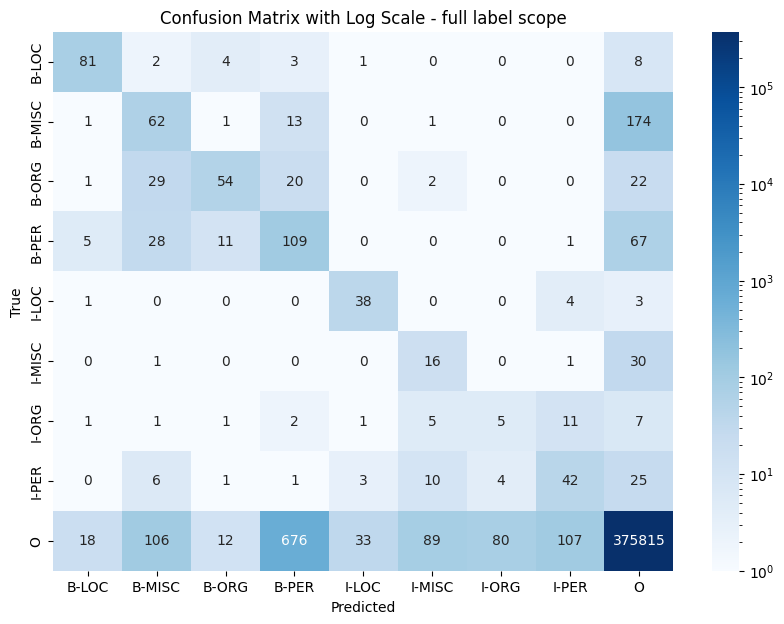

In [22]:
flattened_preds = [label for seq in preds_str for label in seq]
flattened_true_labels = [label for seq in true_labels_str for label in seq]

conf_matrix = confusion_matrix(flattened_true_labels, flattened_preds, labels=list(id2tag_ner.values()))

viz_matrix = np.where(conf_matrix == 0, 1, conf_matrix)


plt.figure(figsize=(10, 7))
sns.heatmap(viz_matrix, annot=conf_matrix, fmt="d", cmap="Blues", 
            xticklabels=list(id2tag_ner.values()), 
            yticklabels=list(id2tag_ner.values()), 
            norm=mcolors.LogNorm(vmin=1, vmax=conf_matrix.max()))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Log Scale - full label scope')
plt.show()


### 2.b. NER entite classification for Cultural model

In [14]:
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "cultural_ref"])

In [15]:
# tokenized_cultural_test[1]

In [18]:
all_predictions_cultural = []
all_true_labels_cultural = []
all_word_ids_cultural = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        true_labels_cultural = batch["cultural_ref"]
        
        outputs = cultural_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        all_predictions_cultural.extend(predictions.tolist())
        all_true_labels_cultural.extend(true_labels_cultural.tolist())
        all_word_ids_cultural.extend(input_ids.tolist())

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [19]:
preds_str_c = [[id2tag_cultural[pred] for pred in seq] for seq in all_predictions_cultural]
true_labels_str_c= [
    [id2tag_cultural[label] if label != -100 else "-" for label in seq] 
    for seq in all_true_labels_cultural]

##### Evalution of Cultural Classification model

In [26]:
#without "-"
def filter_o_labels(true, pred):
    true_f, pred_f = [], []
    for t_seq, p_seq in zip(true, pred):
        for t, p in zip(t_seq, p_seq):
            if t != "-":
                true_f.append(t)
                pred_f.append(p)
    return true_f, pred_f

flat_true_f, flat_preds_f = filter_o_labels(true_labels_str_c, preds_str_c)

print(classification_report(
    flat_true_f,
    flat_preds_f,
    labels=sorted(set(flat_true_f + flat_preds_f)),
    target_names=sorted(set(flat_true_f + flat_preds_f)),
    zero_division=0
))


                precision    recall  f1-score   support

             -       0.00      0.00      0.00         0
       African       0.00      0.00      0.00         1
 Eastern Asian       1.00      0.06      0.12        16
      European       0.52      0.64      0.57       204
         Latin       0.62      0.05      0.09       105
  Middle Asian       0.00      0.00      0.00         3
Middle Eastern       0.00      0.00      0.00         1
  Non cultural       0.48      0.34      0.40        62
North American       0.85      0.59      0.70       514
      Oceanian       0.00      0.00      0.00         4

      accuracy                           0.51       910
     macro avg       0.35      0.17      0.19       910
  weighted avg       0.72      0.51      0.56       910



In [21]:
misclassified_cultural = []

for pred_seq, true_seq, word_id_seq in zip(all_predictions_cultural, all_true_labels_cultural, all_word_ids_cultural):
    for pred_id, true_id, word_id in zip(pred_seq, true_seq, word_id_seq):
        if true_id == -100:
            continue  # skip ignored tokens
        if true_id != pred_id:  # misclassification
            word = tokenizer.convert_ids_to_tokens(word_id)  # get token string
            true_label = id2tag_cultural[true_id]
            pred_label = id2tag_cultural[pred_id]
            misclassified_cultural.append((word_id, word, true_label, pred_label))

df_misclassified_cultural = pd.DataFrame(misclassified_cultural, columns=["word id","Word", "True Label", "Predicted Label"])
df_misclassified_cultural


,word id,Word,True Label,Predicted Label
0,952,▁21,European,-
1,128500,▁techno,Non cultural,North American
2,23,▁in,Non cultural,-
3,339,▁L,North American,European
4,6,▁,North American,European
...,...,...,...,...
653,26842,▁Mega,North American,Non cultural
654,67722,▁gigant,-,European
655,25383,▁MD,North American,Latin
656,29892,▁rap,-,North American


In [22]:
flat_preds_c = [tag for seq, true_seq in zip(preds_str_c, all_true_labels_cultural) 
                for tag, true_id in zip(seq, true_seq) if true_id != -100]

flat_true_c = [tag for seq in true_labels_str_c for tag in seq if tag != '-']

pred_counts = Counter(flat_preds_c)
true_counts = Counter(flat_true_c)


all_tags = sorted(set(flat_preds_c + flat_true_c))


df_counts = pd.DataFrame({
    "True Labels": [true_counts.get(tag, 0) for tag in all_tags],
    "Predicted Labels": [pred_counts.get(tag, 0) for tag in all_tags]
}, index=all_tags)

df_counts["Difference (Pred - True)"] = df_counts["Predicted Labels"] - df_counts["True Labels"]

df_counts


,True Labels,Predicted Labels,Difference (Pred - True)
-,0,25668,25668
African,1,0,-1
Eastern Asian,16,1,-15
European,204,303,99
Latin,105,13,-92
Middle Asian,3,0,-3
Middle Eastern,1,0,-1
Non cultural,62,59,-3
North American,514,497,-17
Oceanian,4,0,-4


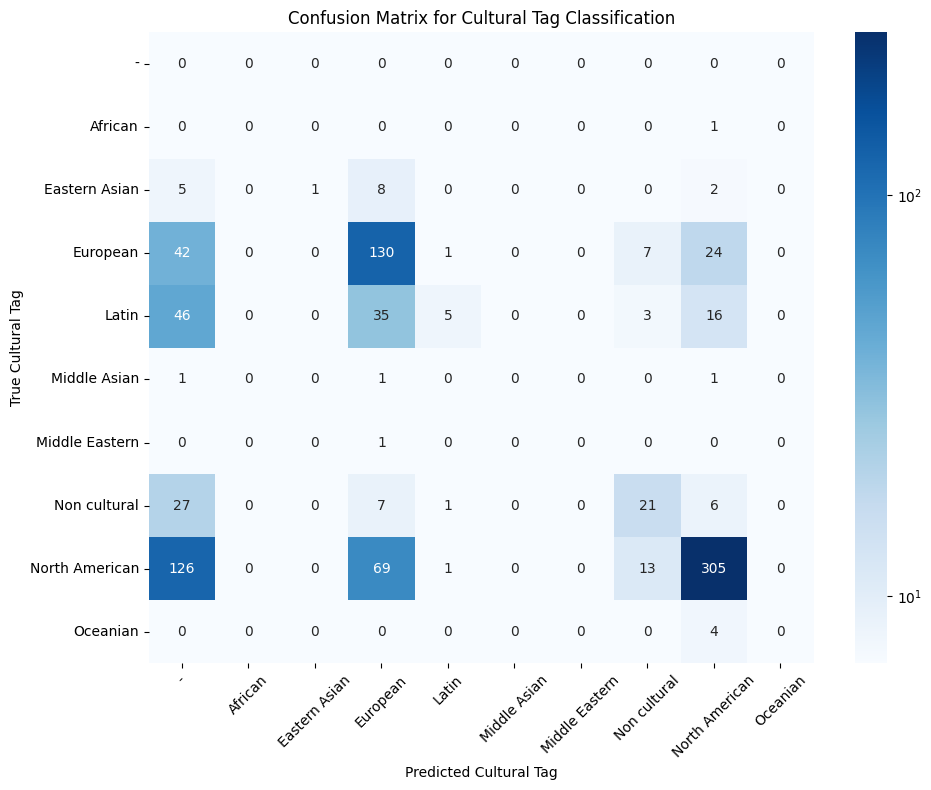

In [23]:
flat_preds_c = [tag for seq in preds_str_c for tag in seq]
flat_true_c = [tag for seq in true_labels_str_c for tag in seq]

filtered_preds = [p for p, t in zip(flat_preds_c, flat_true_c) if t != '-']
filtered_true = [t for t in flat_true_c if t != '-']

labels = sorted(set(filtered_true + filtered_preds))

cm = confusion_matrix(filtered_true, filtered_preds, labels=labels)

viz_cm = np.where(cm == 0, 1, cm)

plt.figure(figsize=(10, 8))
sns.heatmap(
    viz_cm,
    annot=cm,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    norm=SymLogNorm(linthresh=50, linscale=1.0, vmin=1, vmax=cm.max())
)
plt.xlabel("Predicted Cultural Tag")
plt.ylabel("True Cultural Tag")
plt.title("Confusion Matrix for Cultural Tag Classification")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### Analisys of latin of cultural tags

In [74]:
df_latin = df_misclassified_cultural[df_misclassified_cultural["True Label"] == "Latin"]

In [75]:
pd.set_option('display.max_rows', 115) 
display(df_latin)

,word id,Word,True Label,Predicted Label
8,17182,▁peso,Latin,-
12,930,▁Da,Latin,North American
14,911,▁Ma,Latin,European
16,17182,▁peso,Latin,-
17,335,▁B,Latin,North American
18,104099,▁Javier,Latin,European
19,87,▁I,Latin,European
20,4697,▁Kas,Latin,European
22,180,▁O,Latin,European
26,65787,▁Rub,Latin,European


In [76]:
df_latin.groupby("Predicted Label")["Word"].apply(list).reset_index()


,Predicted Label,Word
0,-,"[▁peso, ▁peso, ▁cab, ▁bebe, ▁cosmo, ▁Java, ▁Ru..."
1,European,"[▁Ma, ▁Javier, ▁I, ▁Kas, ▁O, ▁Rub, ▁Erik, ▁Rum..."
2,Non cultural,"[▁Señor, ▁Ro, ▁The]"
3,North American,"[▁Da, ▁B, ▁B, ▁B, ▁Gana, ▁AA, ▁Bad, ▁Bun, ▁Mac..."


In [77]:
grouped = df_latin.groupby("Predicted Label")["Word"].apply(list).reset_index()

# Count unique words and frequencies
grouped["Word Counts"] = grouped["Word"].apply(lambda words: dict(pd.Series(words).value_counts()))
grouped["Unique Words"] = grouped["Word"].apply(lambda x: len(set(x)))

merged_df = grouped.drop(columns="Word")

In [ ]:
rows = []
for _, row in merged_df.iterrows():
    pred_label = row["Predicted Label"]
    word_counts = row["Word Counts"]
    for word, count in word_counts.items():
        clean_word = word.lstrip("▁")
        rows.append({"Predicted Label": pred_label, "Word": clean_word, "Count": count})

df_flat = pd.DataFrame(rows)
df_flat = df_flat.sort_values(["Predicted Label", "Count"], ascending=[True, False])
df_flat

,Predicted Label,Word,Count
0,-,cab,17
1,-,peso,2
2,-,Ya,2
3,-,Ha,2
4,-,Lo,2
5,-,Que,2
6,-,Me,2
7,-,La,2
8,-,y,2
9,-,ju,1


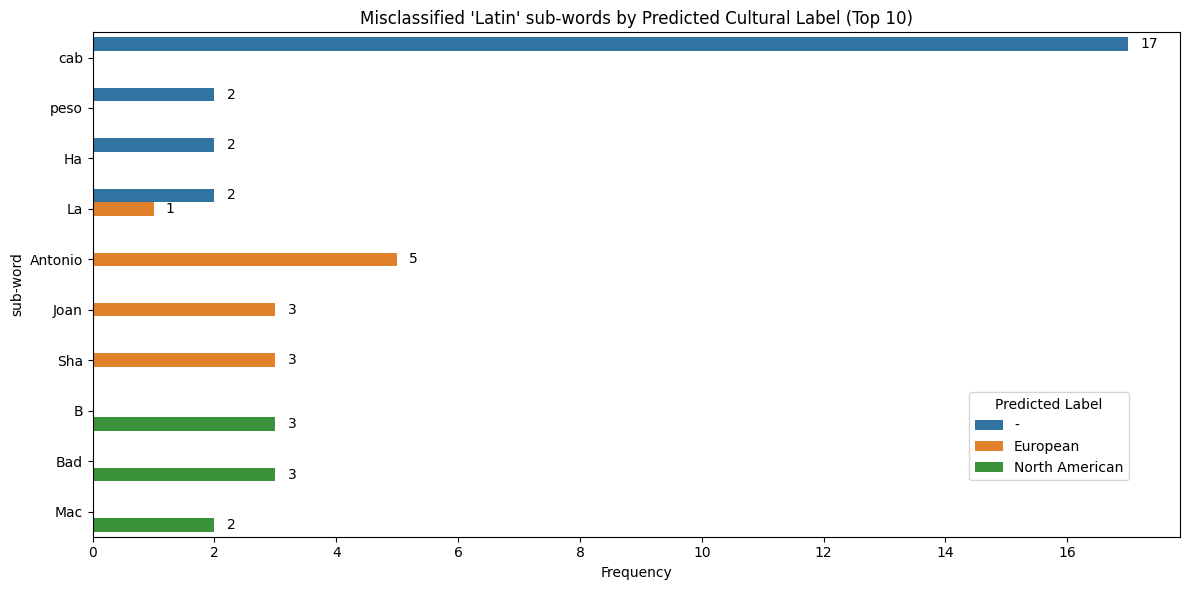

In [90]:
top_n_words = df_flat.groupby("Word")["Count"].sum().sort_values(ascending=False).head(10).index

df_filtered = df_flat[df_flat["Word"].isin(top_n_words)]

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x="Count", y="Word", hue="Predicted Label", dodge=True)

plt.title("Misclassified 'Latin' sub-words by Predicted Cultural Label (Top 10)")
plt.xlabel("Frequency")
plt.ylabel("sub-word")
plt.legend(title="Predicted Label", bbox_to_anchor=(0.8, 0.3), loc='upper left')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 0.2, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

plt.tight_layout()
plt.show()

## 3. Merged classification:

In [ ]:
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels" ,"cultural_ref"])

In [ ]:
ner_id2label = ner_model.config.id2label
cult_id2label = cultural_model.config.id2label

In [ ]:
all_predictions_combined = []
all_word_ids_combined = [] 

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]

        true_labels_ner = batch["labels"]
        true_labels_cultural = batch["cultural_ref"]

        ner_outputs = ner_model(input_ids=input_ids, attention_mask=attention_mask)
        cultural_outputs = cultural_model(input_ids=input_ids, attention_mask=attention_mask)

        ner_preds = torch.argmax(ner_outputs.logits, dim=-1)
        cultural_preds = torch.argmax(cultural_outputs.logits, dim=-1)

        for ner_seq, cult_seq, input_id_seq in zip(ner_preds, cultural_preds, input_ids):
            combined_seq = []
            
            for ner_tag_id, cult_tag_id in zip(ner_seq, cult_seq):
                ner_tag = id2tag_ner[ner_tag_id.item()]
                if ner_tag == "O":
                    combined_seq.append((ner_tag, "-"))
                else:
                    cult_tag = id2tag_cultural[cult_tag_id.item()]
                    combined_seq.append((ner_tag, cult_tag))
            
            all_predictions_combined.append(combined_seq)
            all_word_ids_combined.append(input_id_seq.tolist())


In [ ]:
#check if tagger and clutural tagger worked
for combined_seq, word_ids_seq in zip(all_predictions_combined, all_word_ids_combined):
    words = tokenizer.convert_ids_to_tokens(word_ids_seq)
    for (ner_tag, cultural_tag), word in zip(combined_seq, words):
        if ner_tag != "O":
            print(f"Word: {word} | NER tag: {ner_tag} => Cultural tag: {cultural_tag}")


Word: ▁Mil | NER tag: B-LOC => Cultural tag: European
Word: án | NER tag: I-LOC => Cultural tag: European
Word: ▁Pra | NER tag: B-ORG => Cultural tag: European
Word: da | NER tag: I-ORG => Cultural tag: European
Word: ▁Berlín | NER tag: B-LOC => Cultural tag: European
Word: ▁techno | NER tag: B-MISC => Cultural tag: North American
Word: ▁WhatsApp | NER tag: B-MISC => Cultural tag: North American
Word: ▁Miami | NER tag: B-LOC => Cultural tag: North American
Word: ▁L | NER tag: B-LOC => Cultural tag: European
Word: ▁ | NER tag: I-LOC => Cultural tag: European
Word: . | NER tag: I-LOC => Cultural tag: European
Word: ▁A | NER tag: I-LOC => Cultural tag: European
Word: . | NER tag: I-LOC => Cultural tag: -
Word: ▁Madrid | NER tag: B-LOC => Cultural tag: European
Word: ▁Ferrari | NER tag: B-MISC => Cultural tag: European
Word: ▁reggae | NER tag: B-MISC => Cultural tag: North American
Word: tón | NER tag: I-MISC => Cultural tag: -
Word: ▁Da | NER tag: B-PER => Cultural tag: North American
Wor

In [ ]:
comparison_data = []

for sentence_data, ner_true_seq, cult_true_seq, ner_pred_seq, cult_pred_seq in zip(
    test_data, all_true_labels_ner, all_true_labels_cultural,
    all_predictions_ner, all_predictions_cultural
):
    tokens = sentence_data["tokens"]
    word_idx = 0
    
    for true_ner, pred_ner, true_cult, pred_cult in zip(
        ner_true_seq, ner_pred_seq, cult_true_seq, cult_pred_seq
    ):
        if true_ner == -100 or true_cult == -100:
            continue

        if word_idx >= len(tokens):
            break

        true_ner_tag = id2tag_ner[true_ner]
        pred_ner_tag = id2tag_ner[pred_ner]

        if (true_ner_tag == "O" and pred_ner_tag != "O") or (true_ner_tag != "O" and true_ner_tag != pred_ner_tag):
            comparison_data.append({
                "Word": tokens[word_idx],
                "True NER": true_ner_tag,
                "True Cultural Tag": id2tag_cultural[true_cult],
                "Predicted NER": pred_ner_tag,
                "Predicted Cultural Tag": id2tag_cultural[pred_cult]
            })

        word_idx += 1


df_comparison = pd.DataFrame(comparison_data)
df_comparison.index.name = "Word Index"

df_comparison

,Word,True NER,True Cultural Tag,Predicted NER,Predicted Cultural Tag
Word Index,,,,,
0,21,B-MISC,European,O,-
1,infierno,B-MISC,Non cultural,O,-
2,WhatsApp,B-ORG,North American,B-MISC,North American
3,.,I-LOC,North American,O,-
4,Backlash,B-MISC,North American,O,North American
...,...,...,...,...,...
651,bulería,B-MISC,European,O,-
652,historieta,O,-,B-MISC,-
653,Pilot,B-ORG,European,B-MISC,European


In [ ]:
comparison_data = []

for sentence_data, ner_true_seq, cult_true_seq, ner_pred_seq, cult_pred_seq in zip(
    test_data, all_true_labels_ner, all_true_labels_cultural,
    all_predictions_ner, all_predictions_cultural
):
    tokens = sentence_data["tokens"]
    word_idx = 0
    
    for true_ner, pred_ner, true_cult, pred_cult in zip(
        ner_true_seq, ner_pred_seq, cult_true_seq, cult_pred_seq
    ):
        if true_ner == -100 or true_cult == -100:
            continue

        if word_idx >= len(tokens):
            break

        true_ner_tag = id2tag_ner[true_ner]
        pred_ner_tag = id2tag_ner[pred_ner]
        true_cult_tag = id2tag_cultural[true_cult]
        pred_cult_tag = id2tag_cultural[pred_cult]

        # Include only if both NER and cultural predictions are wrong
        if true_ner_tag != pred_ner_tag and true_cult_tag != pred_cult_tag:
            comparison_data.append({
                "Word": tokens[word_idx],
                "True NER": true_ner_tag,
                "True Cultural Tag": true_cult_tag,
                "Predicted NER": pred_ner_tag,
                "Predicted Cultural Tag": pred_cult_tag
            })

        word_idx += 1

df_comparison = pd.DataFrame(comparison_data)
df_comparison.index.name = "Word Index"

df_comparison


,Word,True NER,True Cultural Tag,Predicted NER,Predicted Cultural Tag
Word Index,,,,,
0,21,B-MISC,European,O,-
1,infierno,B-MISC,Non cultural,O,-
2,.,I-LOC,North American,O,-
3,Limo,B-MISC,North American,O,European
4,peso,B-MISC,Latin,O,-
...,...,...,...,...,...
412,parafina,B-MISC,European,O,-
413,jia-jia,B-MISC,Eastern Asian,O,-
414,bulería,B-MISC,European,O,-


In [ ]:
true_joint_labels = [
    f"{row['True NER']} | {row['True Cultural Tag']}"
    for _, row in df_comparison.iterrows()
]
pred_joint_labels = [
    f"{row['Predicted NER']} | {row['Predicted Cultural Tag']}"
    for _, row in df_comparison.iterrows()
]


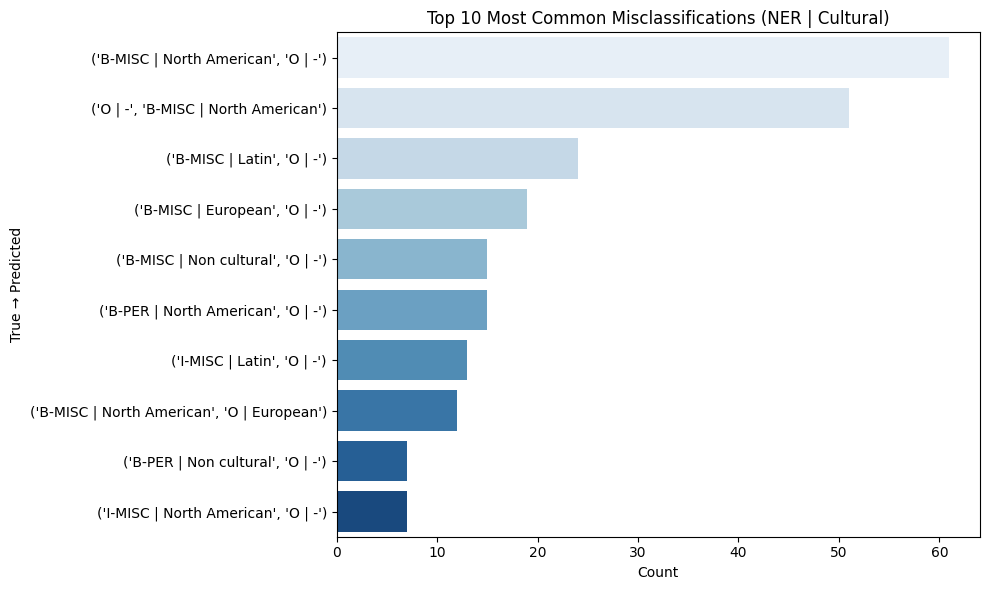

In [ ]:
#10 most missclassified tags
misclass_pairs = list(zip(true_joint_labels, pred_joint_labels))
counter = Counter(misclass_pairs)

df_misclass_freq = pd.DataFrame(counter.items(), columns=["Pair", "Count"])
df_misclass_freq = df_misclass_freq.sort_values("Count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_misclass_freq, y="Pair", x="Count", palette="Blues")
plt.title("Top 10 Most Common Misclassifications (NER | Cultural)")
plt.xlabel("Count")
plt.ylabel("True → Predicted")
plt.tight_layout()
plt.show()


In [ ]:
true_ner_flat = []
pred_ner_flat = []
true_culture_flat = []
pred_culture_flat = []

for ner_true_seq, ner_pred_seq, cult_true_seq, cult_pred_seq in zip(
    all_true_labels_ner, all_predictions_ner, all_true_labels_cultural, all_predictions_cultural
):
    for ner_t, ner_p, cult_t, cult_p in zip(ner_true_seq, ner_pred_seq, cult_true_seq, cult_pred_seq):
        if ner_t != -100 and cult_t != -100:
            true_ner_flat.append(id2tag_ner[ner_t])
            pred_ner_flat.append(id2tag_ner[ner_p])
            true_culture_flat.append(id2tag_cultural[cult_t])
            pred_culture_flat.append(id2tag_cultural[cult_p])

entity_indices = [i for i, tag in enumerate(true_ner_flat) if tag != 'O' and tag != '-']

true_joint = [f"{true_ner_flat[i]} | {true_culture_flat[i]}" for i in entity_indices]
pred_joint = [f"{pred_ner_flat[i]} | {pred_culture_flat[i]}" for i in entity_indices]

report_dict = classification_report(true_joint, pred_joint, zero_division=0, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()


report_df.iloc[:, :-1] = report_df.iloc[:, :-1].round(3)

print(report_df)

                         precision  recall  f1-score     support
B-LOC | -                    0.000   0.000     0.000    0.000000
B-LOC | European             0.400   0.625     0.488   16.000000
B-LOC | Latin                1.000   0.250     0.400    4.000000
B-LOC | Middle Asian         0.000   0.000     0.000    1.000000
B-LOC | Non cultural         0.000   0.000     0.000    2.000000
B-LOC | North American       0.875   0.662     0.754   74.000000
B-LOC | Oceanian             0.000   0.000     0.000    2.000000
B-MISC | -                   0.000   0.000     0.000    0.000000
B-MISC | Eastern Asian       0.000   0.000     0.000    7.000000
B-MISC | European            0.056   0.077     0.065   26.000000
B-MISC | Latin               0.000   0.000     0.000   29.000000
B-MISC | Middle Asian        0.000   0.000     0.000    2.000000
B-MISC | Non cultural        0.800   0.129     0.222   31.000000
B-MISC | North American      0.515   0.217     0.305  157.000000
B-ORG | -                